In [117]:
from imblearn.over_sampling import SMOTE
from inspect import signature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Import Data And Take Initial Look

In [10]:
raw_dataset = pd.read_csv('data/dataset.csv', sep=";")
raw_dataset.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [11]:
raw_dataset.shape

(99976, 43)

We have roughly 100,000 total rows of data.

In [43]:
len(set(raw_dataset.uuid))

99976

Each row represents a different uuid, so we can use this as our index down the line.

In [12]:
sum(raw_dataset.default.fillna(0))

1288.0

Of those 100,000 rows, 1,288 are defaults. <br>
This means we have an imbalanced dataset (so we'll use SMOTE to balance it out).<br>

In [13]:
len(raw_dataset[raw_dataset['default'].isnull()].index.tolist())

10000

10% of this dataset is unlabeled. So let's separate out these indices to know what we're training on v. predicting on.

In [16]:
raw_dataset.isnull().sum()/raw_dataset.shape[0]

uuid                                   0.000000
default                                0.100024
account_amount_added_12_24m            0.000000
account_days_in_dc_12_24m              0.118388
account_days_in_rem_12_24m             0.118388
account_days_in_term_12_24m            0.118388
account_incoming_debt_vs_paid_0_24m    0.593292
account_status                         0.543861
account_worst_status_0_3m              0.543861
account_worst_status_12_24m            0.667770
account_worst_status_3_6m              0.577159
account_worst_status_6_12m             0.603645
age                                    0.000000
avg_payment_span_0_12m                 0.238417
avg_payment_span_0_3m                  0.493168
merchant_category                      0.000000
merchant_group                         0.000000
has_paid                               0.000000
max_paid_inv_0_12m                     0.000000
max_paid_inv_0_24m                     0.000000
name_in_email                          0

Some rows have a very large proportion of nulls.<br>
Depending on the application, we can strategically impute these values. But since I'm not familiar with where these variables are coming from, I'm going to take the convenient route and drop any columns with > 20% null values. We will impute the NULL values after performing the train-test split.

# Data Cleaning

We need to do a few things here:
<ul>
    <li> Remove the columns with > 20% NULL values </li>
    <li> Convert categorical variables into dummy variables </li>
    <li> Convert Boolean variables from True/False to 1/0 </li>
    <li> Set UUID to the index so that it's not being used as an input variable </li>

### 1. Remove NULLs

In [23]:
null_percentages = raw_dataset.isnull().sum()/raw_dataset.shape[0]
null_valid_indices = [idx for idx in range(null_percentages.shape[0]) if null_percentages.iloc[idx] < 0.2]
print(null_valid_indices)

[0, 1, 2, 3, 4, 5, 12, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]


In [25]:
null_cleaned_dataset = raw_dataset.iloc[:, null_valid_indices]

In [26]:
null_cleaned_dataset.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,merchant_category,merchant_group,has_paid,...,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,20,Dietary supplements,Health & Beauty,True,...,1,1,1,1,1,0,0,0,178839,9.653333
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,50,Books & Magazines,Entertainment,True,...,1,1,1,2,2,0,0,0,49014,13.181389
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,22,Diversified entertainment,Entertainment,True,...,1,1,1,2,2,0,0,0,124839,11.561944
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,36,Diversified entertainment,Entertainment,True,...,1,1,1,1,1,0,0,0,324676,15.751111
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,25,Electronic equipment & Related accessories,Electronics,True,...,0,0,1,1,1,0,0,0,7100,12.698611


### 2. Dummify Categorical Features

In [54]:
# I've Commented out columns that were removed with the null filter
categorical_features = [
#     'account_status', 
#     'account_worst_status_0_3m',
#     'account_worst_status_12_24m',
#     'account_worst_status_3_6m',
#     'account_worst_status_6_12m',
    'merchant_category',
    'merchant_group',
    'name_in_email',
    'status_last_archived_0_24m',
    'status_2nd_last_archived_0_24m',
    'status_3rd_last_archived_0_24m',
    'status_max_archived_0_6_months',
    'status_max_archived_0_12_months',
    'status_max_archived_0_24_months',
#     'worst_status_active_inv'
]
other_features = [val for val in null_cleaned_dataset.columns if val not in categorical_features]

In [55]:
dummy_subset = pd.get_dummies(null_cleaned_dataset.loc[:, categorical_features])
dummy_subset.shape

(99976, 83)

In [56]:
dummified_dataset = pd.concat((null_cleaned_dataset.loc[:, other_features], dummy_subset), axis=1)
dummified_dataset.shape

(99976, 107)

Since we have a large number of columns we can do 2 things to train a better model:
<ol>
    <li> Perform PCA </li>
    <li> Train more and larger XGBoost trees to account for all the variables </li>
</ol><br>
For the MVP's sake, we will simply train more large XGBoost trees instead of using PCA.

### 3. Convert Boolean Features from True/False to 1/0

In [57]:
fixed_boolean_dataset = dummified_dataset.copy()
fixed_boolean_dataset['has_paid'] = fixed_boolean_dataset['has_paid'] * 1
fixed_boolean_dataset['has_paid'].head(2)

0    1
1    1
Name: has_paid, dtype: int64

### 3. Set UUID to the index

In [58]:
dataset = fixed_boolean_dataset.set_index('uuid')
dataset.head()

,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_inv,...,merchant_group_Jewelry & Accessories,"merchant_group_Leisure, Sport & Hobby",name_in_email_F,name_in_email_F+L,name_in_email_F1+L,name_in_email_Initials,name_in_email_L,name_in_email_L1+F,name_in_email_Nick,name_in_email_no_match
uuid,,,,,,,,,,,,,,,,,,,,,
63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,20,1,31638.0,31638.0,2,...,0,0,0,0,0,0,0,0,0,1
0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,50,1,13749.0,13749.0,0,...,0,0,0,1,0,0,0,0,0,0
d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,22,1,29890.0,29890.0,1,...,0,0,0,0,0,0,0,1,0,0
0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,36,1,40040.0,40040.0,1,...,0,0,0,0,1,0,0,0,0,0
c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,25,1,7100.0,7100.0,0,...,0,0,0,1,0,0,0,0,0,0


Beautiful! Now let's perform out data split and oversampling!

# Train-Validation-Test Split and Oversampling

### 1. Perform Train-Test-Validation Split

In [70]:
feature_columns = [val for val in dataset.columns if val != 'default']

In [71]:
holdout_indices = dataset[dataset['default'].isnull()].index.tolist()
X_holdout, y_holdout = dataset.loc[holdout_indices, feature_columns], dataset.loc[holdout_indices, 'default']

In [72]:
non_holdout_indices = np.setdiff1d(dataset.index, holdout_indices)
non_holdout = dataset.loc[non_holdout_indices, :]
non_holdout.shape

(89976, 106)

In [73]:
X, y = non_holdout.loc[:, feature_columns], non_holdout.loc[:, 'default']
# We want a larger test size so that we are less prone to extreme cases where we have very
# few default cases in the validation set.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

### 2. Impute NaN values to allow for SMOTE transformation

In [81]:
null_counts = X_train.isnull().sum()/X_train.shape[0]
idx = 0
for val in null_counts:
    if val > 0:
        print(null_counts.index[idx], null_counts[idx])
    idx += 1

account_days_in_dc_12_24m 0.11731333875221871
account_days_in_rem_12_24m 0.11731333875221871
account_days_in_term_12_24m 0.11731333875221871
num_arch_written_off_0_12m 0.1818091335865833
num_arch_written_off_12_24m 0.1818091335865833


In [100]:
(X_train
    .loc[~np.isnan(X_train.account_days_in_dc_12_24m),:]
    .groupby('account_days_in_dc_12_24m')
    .count()
    .loc[0:20, 'account_amount_added_12_24m']
)

account_days_in_dc_12_24m
0.0     53055
1.0         1
3.0         2
4.0         1
5.0         1
7.0         4
9.0         8
10.0        1
11.0        2
12.0        1
13.0        3
14.0        1
17.0        1
18.0        1
20.0        1
Name: account_amount_added_12_24m, dtype: int64

Clearly we should impute with the mode here, 0.

In [105]:
(X_train
    .loc[~np.isnan(X_train.account_days_in_rem_12_24m),:]
    .groupby('account_days_in_rem_12_24m')
    .count()
)

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_term_12_24m,age,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,...,merchant_group_Jewelry & Accessories,"merchant_group_Leisure, Sport & Hobby",name_in_email_F,name_in_email_F+L,name_in_email_F1+L,name_in_email_Initials,name_in_email_L,name_in_email_L1+F,name_in_email_Nick,name_in_email_no_match
account_days_in_rem_12_24m,,,,,,,,,,,,,,,,,,,,,
0.0,47358,47358,47358,47358,47358,47358,47358,47358,47358,47358,...,47358,47358,47358,47358,47358,47358,47358,47358,47358,47358
1.0,324,324,324,324,324,324,324,324,324,324,...,324,324,324,324,324,324,324,324,324,324
2.0,186,186,186,186,186,186,186,186,186,186,...,186,186,186,186,186,186,186,186,186,186
3.0,129,129,129,129,129,129,129,129,129,129,...,129,129,129,129,129,129,129,129,129,129
4.0,99,99,99,99,99,99,99,99,99,99,...,99,99,99,99,99,99,99,99,99,99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354.0,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
356.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
358.0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Clearly we'll impute here with 0 as well.

In [108]:
(X_train
    .loc[~np.isnan(X_train.account_days_in_term_12_24m),:]
    .groupby('account_days_in_term_12_24m')
    .count()
    .iloc[:10]
)

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,age,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_inv,num_arch_dc_0_12m,num_arch_dc_12_24m,...,merchant_group_Jewelry & Accessories,"merchant_group_Leisure, Sport & Hobby",name_in_email_F,name_in_email_F+L,name_in_email_F1+L,name_in_email_Initials,name_in_email_L,name_in_email_L1+F,name_in_email_Nick,name_in_email_no_match
account_days_in_term_12_24m,,,,,,,,,,,,,,,,,,,,,
0.0,52460,52460,52460,52460,52460,52460,52460,52460,52460,52460,...,52460,52460,52460,52460,52460,52460,52460,52460,52460,52460
1.0,34,34,34,34,34,34,34,34,34,34,...,34,34,34,34,34,34,34,34,34,34
2.0,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
3.0,24,24,24,24,24,24,24,24,24,24,...,24,24,24,24,24,24,24,24,24,24
4.0,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
5.0,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
6.0,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
7.0,35,35,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
8.0,26,26,26,26,26,26,26,26,26,26,...,26,26,26,26,26,26,26,26,26,26


This will be imputed with 0 as well.

In [109]:
(X_train
    .loc[~np.isnan(X_train.num_arch_written_off_0_12m),:]
    .groupby('num_arch_written_off_0_12m')
    .count()
    .iloc[:10]
)

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_inv,num_arch_dc_0_12m,...,merchant_group_Jewelry & Accessories,"merchant_group_Leisure, Sport & Hobby",name_in_email_F,name_in_email_F+L,name_in_email_F1+L,name_in_email_Initials,name_in_email_L,name_in_email_L1+F,name_in_email_Nick,name_in_email_no_match
num_arch_written_off_0_12m,,,,,,,,,,,,,,,,,,,,,
0.0,49319,43613,43613,43613,49319,49319,49319,49319,49319,49319,...,49319,49319,49319,49319,49319,49319,49319,49319,49319,49319
1.0,4,3,3,3,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


0 imputation here as well.

In [110]:
(X_train
    .loc[~np.isnan(X_train.num_arch_written_off_12_24m),:]
    .groupby('num_arch_written_off_12_24m')
    .count()
    .iloc[:10]
)

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,age,has_paid,max_paid_inv_0_12m,max_paid_inv_0_24m,num_active_inv,num_arch_dc_0_12m,...,merchant_group_Jewelry & Accessories,"merchant_group_Leisure, Sport & Hobby",name_in_email_F,name_in_email_F+L,name_in_email_F1+L,name_in_email_Initials,name_in_email_L,name_in_email_L1+F,name_in_email_Nick,name_in_email_no_match
num_arch_written_off_12_24m,,,,,,,,,,,,,,,,,,,,,
0.0,49318,43612,43612,43612,49318,49318,49318,49318,49318,49318,...,49318,49318,49318,49318,49318,49318,49318,49318,49318,49318
1.0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2.0,1,0,0,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Yep, and 0 imputation here too.<br>

All of the NaN values can be imputed by 0, which makes our job very easy.

In [111]:
X_train, X_val, X_holdout = X_train.fillna(0), X_val.fillna(0), X_holdout.fillna(0)

### 3. Perform SMOTE transformation on trainin data

In [113]:
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

print(np.sum(y_smote) / y_smote.shape[0])

0.5


# Modeling
Let's train a vanilla XGBoost model and then evaluate it by looking at:
<ul>
    <li> The F1 Score </li>
    <li> The Precision-Recall Curve </li>
</ul>

### 1. Training model with SMOTE

In [115]:
xgb = XGBClassifier()
xgb.fit(X_smote, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

F1 Score: 0.18712029161603888


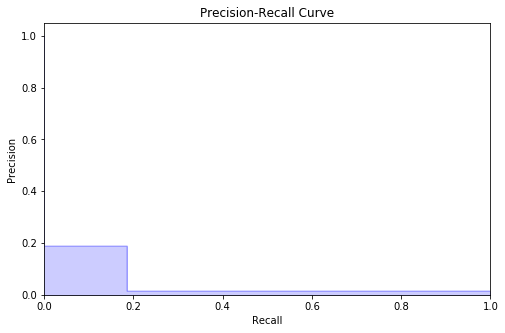

In [121]:
predictions = xgb.predict(X_val.values)
f1 = f1_score(y_val, predictions)
print("F1 Score:", f1)
precision, recall, _ = precision_recall_curve(y_val, predictions)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.rcParams['figure.figsize'] = (8,5)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall Curve")

plt.show()

### 2. Training model without SMOTE

In [124]:
xgb = XGBClassifier()
xgb.fit(X_train.values, y_train.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

F1 Score: 0.037383177570093455


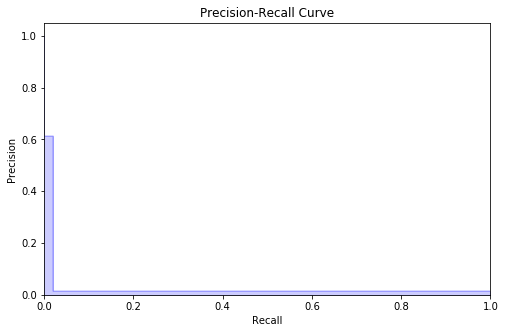

In [125]:
predictions = xgb.predict(X_val.values)
f1 = f1_score(y_val, predictions)
print("F1 Score:", f1)
precision, recall, _ = precision_recall_curve(y_val, predictions)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.rcParams['figure.figsize'] = (8,5)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("Precision-Recall Curve")

plt.show()

The model with SMOTE performs better on the validation set, so let's set up an API using that.

In [ ]:
s